In [2]:
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

## Load Data

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [4]:
data_dir = '../Datasets/ants_bees'
# A map with keys "train" and "val" and values being images
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
# A map with keys "train" and "val" and values being DataLoaders. A DataLoader is an iterable. 
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Visualize data

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

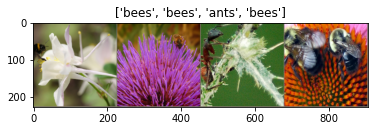

In [6]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch for the visualization purposes
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

#### Test

In [7]:
inputs, classes = next(iter(dataloaders["train"]))
print(classes)

tensor([1, 1, 1, 0])


## Train the model

In [13]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # Move the data to the proper device (GPU or CPU)
                inputs = inputs.to(device) 
                labels = labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) # Need to change
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            # lr_scheduler provides several methods to adjust the learning rate based on the number of epochs
            if phase == 'train':
                scheduler.step()
                
            # Loss and accuracy of the epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Visualize the model predictions

In [23]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetune the ResNet18

In [9]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2) # Need to change

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay learning rate by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## Train and evaluate

In [14]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------
torch.Size([4])
tensor([0, 1, 1, 0])
tensor([[ 1.1074, -2.7397],
        [-1.9018,  0.3054],
        [-2.8117,  0.9692],
        [ 1.5512, -2.4537]], grad_fn=<AddmmBackward0>)



torch.Size([4])
tensor([0, 1, 0, 1])
tensor([[ 1.5890, -4.0025],
        [-2.8126,  0.5476],
        [ 0.9861, -0.4114],
        [-2.0229,  0.2173]], grad_fn=<AddmmBackward0>)



torch.Size([4])
tensor([0, 1, 0, 0])
tensor([[ 1.3779, -3.1013],
        [-2.9508,  1.7940],
        [-0.2476, -1.8550],
        [-0.4570, -0.5582]], grad_fn=<AddmmBackward0>)



torch.Size([4])
tensor([0, 1, 1, 1])
tensor([[ 1.0123, -2.6113],
        [ 0.0471, -0.8460],
        [-2.0746,  0.0451],
        [-1.2549, -0.2076]], grad_fn=<AddmmBackward0>)



torch.Size([4])
tensor([0, 0, 1, 0])
tensor([[ 2.0541, -2.7964],
        [ 0.1987, -2.4525],
        [-3.2917,  1.8642],
        [-1.7926,  0.2844]], grad_fn=<AddmmBackward0>)



torch.Size([4])
tensor([1, 0, 0, 0])
tensor([[-0.7704, -0.8028],
        [-1.5022,  

torch.Size([4])
tensor([0, 0, 1, 0])
tensor([[-2.0663, -0.2584],
        [ 0.5789, -1.7083],
        [-2.8059,  2.1401],
        [-2.0669,  0.4770]], grad_fn=<AddmmBackward0>)



torch.Size([4])
tensor([0, 1, 1, 1])
tensor([[ 4.2285, -5.0976],
        [-1.8409,  1.0186],
        [-1.5217,  0.0182],
        [-4.9816,  2.4483]], grad_fn=<AddmmBackward0>)



torch.Size([4])
tensor([1, 1, 0, 0])
tensor([[-5.2413,  4.0489],
        [ 1.4613, -2.6470],
        [ 1.3530, -3.4171],
        [ 0.3468, -1.7235]], grad_fn=<AddmmBackward0>)



torch.Size([4])
tensor([0, 1, 1, 0])
tensor([[ 0.6649, -1.2884],
        [-3.0653,  1.2670],
        [-0.6145, -1.0422],
        [ 3.0059, -4.6811]], grad_fn=<AddmmBackward0>)



torch.Size([4])
tensor([1, 0, 0, 0])
tensor([[-4.2307,  2.2751],
        [ 2.1404, -3.9792],
        [ 2.1288, -4.1808],
        [ 1.0402, -1.2113]], grad_fn=<AddmmBackward0>)



torch.Size([4])
tensor([1, 1, 1, 1])
tensor([[ 0.7880, -2.4416],
        [-0.5794, -0.3226],
        [ 0.

torch.Size([4])
tensor([0, 0, 0, 1])
tensor([[ 3.9171, -5.1902],
        [-4.2952,  1.3893],
        [ 2.2703, -3.6104],
        [-5.9641,  4.4755]])



torch.Size([4])
tensor([0, 1, 1, 0])
tensor([[ 3.3358, -5.0311],
        [-5.8258,  2.7217],
        [-4.3520,  2.0625],
        [ 2.0600, -4.0626]])



torch.Size([1])
tensor([1])
tensor([[-2.3945,  1.4455]])



val Loss: 0.3746 Acc: 0.8693

Epoch 1/4
----------
torch.Size([4])
tensor([0, 0, 1, 1])
tensor([[ 1.9414, -2.8402],
        [ 1.7728, -2.2544],
        [-7.2254,  4.4596],
        [-3.7566,  2.0787]], grad_fn=<AddmmBackward0>)



torch.Size([4])
tensor([1, 1, 1, 0])
tensor([[-2.3548,  0.8365],
        [-0.9141,  0.4046],
        [-2.6326,  0.9767],
        [-1.5313, -0.8446]], grad_fn=<AddmmBackward0>)



torch.Size([4])
tensor([1, 0, 1, 0])
tensor([[-3.4730,  1.3528],
        [ 1.6802, -2.2879],
        [-6.4591,  4.9966],
        [ 1.5079, -3.1070]], grad_fn=<AddmmBackward0>)



torch.Size([4])
tensor([0, 1, 1, 1])
tensor([[

torch.Size([4])
tensor([0, 1, 0, 1])
tensor([[-1.0657,  0.0317],
        [-3.6757,  1.8249],
        [ 1.4236, -3.1746],
        [-4.7305,  3.4287]], grad_fn=<AddmmBackward0>)



torch.Size([4])
tensor([1, 1, 1, 0])
tensor([[-3.9091,  2.7659],
        [-3.5422,  1.0739],
        [-3.2526,  1.7918],
        [ 2.8481, -3.7141]], grad_fn=<AddmmBackward0>)



torch.Size([4])
tensor([0, 1, 0, 0])
tensor([[ 0.4086, -3.0723],
        [-2.0366,  1.2023],
        [-3.2768,  2.0145],
        [-2.6344,  1.4551]], grad_fn=<AddmmBackward0>)



torch.Size([4])
tensor([0, 0, 0, 1])
tensor([[-2.4176,  0.6137],
        [ 0.8911, -1.3777],
        [-1.1647, -1.2747],
        [-3.5924,  2.3201]], grad_fn=<AddmmBackward0>)



torch.Size([4])
tensor([0, 0, 1, 1])
tensor([[-1.3686, -0.3377],
        [ 3.4806, -4.8406],
        [-2.6842,  2.0848],
        [-3.9661,  1.9370]], grad_fn=<AddmmBackward0>)



torch.Size([4])
tensor([1, 1, 0, 1])
tensor([[-2.0408, -0.2402],
        [-0.0833, -1.0652],
        [ 2.

torch.Size([4])
tensor([0, 1, 1, 1])
tensor([[ 4.0474, -5.2789],
        [-3.2596,  1.4522],
        [-3.9496,  1.9077],
        [-1.5542,  0.2787]])



torch.Size([4])
tensor([1, 0, 1, 1])
tensor([[-2.5999, -0.3336],
        [ 1.7858, -2.6883],
        [ 0.7923, -3.6700],
        [-2.3751,  1.6630]])



torch.Size([4])
tensor([0, 0, 1, 1])
tensor([[ 5.0760, -5.3281],
        [ 3.8995, -3.9988],
        [-1.2809, -0.4917],
        [-3.1722,  0.8401]])



torch.Size([4])
tensor([1, 0, 0, 0])
tensor([[-1.8638, -1.2756],
        [ 1.2523, -2.1142],
        [ 3.4158, -3.8521],
        [ 4.1212, -5.5385]])



torch.Size([1])
tensor([1])
tensor([[-2.2989,  1.0138]])



val Loss: 0.5087 Acc: 0.8105

Epoch 2/4
----------
torch.Size([4])
tensor([1, 0, 0, 1])
tensor([[-2.9108,  1.5684],
        [ 2.2658, -3.2565],
        [ 3.3689, -4.6846],
        [-3.1388,  0.8045]], grad_fn=<AddmmBackward0>)



torch.Size([4])
tensor([0, 1, 0, 0])
tensor([[-2.4966,  0.0611],
        [-0.8295, -0.2943],
     

torch.Size([4])
tensor([1, 1, 1, 1])
tensor([[-0.8883, -0.2565],
        [-0.7080, -0.8359],
        [-0.1768, -0.9039],
        [-0.6393, -1.4779]], grad_fn=<AddmmBackward0>)



torch.Size([4])
tensor([0, 1, 1, 0])
tensor([[ 2.2291, -2.9375],
        [-4.7309,  3.0097],
        [-3.0979,  1.0442],
        [ 2.3663, -3.8209]], grad_fn=<AddmmBackward0>)



torch.Size([4])
tensor([0, 1, 1, 0])
tensor([[ 2.6909, -3.9799],
        [-3.9545,  1.9249],
        [-2.7431,  1.6364],
        [ 0.0562, -1.4855]], grad_fn=<AddmmBackward0>)



torch.Size([4])
tensor([0, 1, 1, 0])
tensor([[-1.4422,  0.0142],
        [-1.3741, -0.6578],
        [-2.7182,  1.2973],
        [ 1.2348, -2.2676]], grad_fn=<AddmmBackward0>)



torch.Size([4])
tensor([1, 1, 0, 0])
tensor([[-2.4676,  1.5362],
        [-1.9610,  0.1822],
        [ 0.2665, -1.2335],
        [-0.5664, -1.6148]], grad_fn=<AddmmBackward0>)



torch.Size([4])
tensor([0, 0, 1, 1])
tensor([[ 0.8760, -1.8255],
        [ 1.3129, -2.8762],
        [-3.

KeyboardInterrupt: 

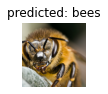

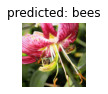

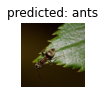

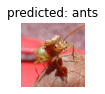

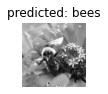

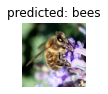

In [27]:
visualize_model(model_ft)